# 17B_magnitude of cooperativity difference

scipy.stats.wilcoxon(x, y=None, zero_method='wilcox', correction=False, alternative='two-sided', mode='auto')[source]
Calculate the Wilcoxon signed-rank test.

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

or Kruskal Wallis test to see if the distributions are different
6/24/21




In [5]:
import scipy.stats
import statsmodels.stats.multitest
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,glob
import numpy as np
import scipy.stats

# 0 get data

In [6]:
mpra_counts = pd.read_csv('../../miseq/mpraanalyze_results/dk_norm/count_matrix_df_normlog.csv',index_col=0)
mpra_counts

mpra_tissues = ['Colon', 'GM', 'COLO', 'MC', 'KCD6', 'A431']
instance_arr = [str(i+1) for i in range(10)]
print(instance_arr)

vocab_arr =sorted(set(['+'.join(x.split('+')[:-2]) for x in list(mpra_counts.index)]))
vocab_arr = [x for x in vocab_arr if len(x)>0]
len(vocab_arr)
# vocab_arr

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


239

In [7]:
# get cooperativity data
normlog_vocab_df_coop = pd.read_csv('../../miseq/mpraanalyze_results/dk_norm_cooperativity/normlog_vocab_df_coop.csv',index_col=0)
print(normlog_vocab_df_coop.tissue.unique())
normlog_vocab_df_coop


['KCD6' 'COLO' 'A431' 'Colon' 'GM' 'MC']


,vocab,instance,tissue,mpra_tissue,orient,value
1,ARID5B::KLF5,1,KCD6,A431,A_B_coop,-0.178150
2,ARID5B::KLF5,1,KCD6,A431,A_B_add,-0.700571
3,ARID5B::KLF5,1,KCD6,COLO,A_B_coop,-0.239885
4,ARID5B::KLF5,1,KCD6,COLO,A_B_add,-0.184670
5,ARID5B::KLF5,1,KCD6,Colon,A_B_coop,-0.085290
...,...,...,...,...,...,...
28676,ZFX::E2F6,9,A431,GM,A_B_add,-2.000000
28677,ZFX::E2F6,9,A431,KCD6,A_B_coop,2.430000
28678,ZFX::E2F6,9,A431,KCD6,A_B_add,-1.660000
28679,ZFX::E2F6,9,A431,MC,A_B_coop,3.280000


In [37]:
# get mpra vocabs + configs
new_mpra_df = pd.read_csv('../data/processed/mpra/results_df_piv_match_count.csv',index_col=0)
print(new_mpra_df.shape)
vocab_to_class = pd.Series(new_mpra_df.consensus_class.values,index=new_mpra_df.vocab.values).to_dict()
# filter for AND VOCABs
new_mpra_df = new_mpra_df[new_mpra_df.consensus_class=='AND']
print(new_mpra_df.shape)
# filter for skin stuff
# new_mpra_df = new_mpra_df[new_mpra_df.tissue.isin(['GDSD6','SCC'])]#,'Melanocytes','MM'])]

# new_mpra_df = new_mpra_df[new_mpra_df.tissue.isin(['MM','SCC'])][['vocab','tissue']].rename(columns={"vocab": "vocab_pair"}).drop_duplicates()
new_mpra_df.columns
scc_krtd6_vocabs = new_mpra_df[new_mpra_df.tissue.isin(['GDSD6','SCC'])].vocab.values
mc_mm_vocabs = new_mpra_df[new_mpra_df.tissue.isin(['Melanocytes','MM'])].vocab.values
len(scc_krtd6_vocabs), len(mc_mm_vocabs)


(239, 9)
(53, 9)


(20, 15)

In [36]:
new_mpra_df[new_mpra_df.vocab.str.contains('MITF')]['class'].values


array(['LEADING_A|LEADING_A|OR|other|OR|other|other|AND|other|other',
       'AND|OR|other|AND|AND|other|AND|AND|AND|other'], dtype=object)

# scc vs krt wilcoxon signed-rank test scores

In [13]:
scc_krt_df = normlog_vocab_df_coop[normlog_vocab_df_coop.tissue.isin(['KCD6','A431'])]
scc_krt_df = scc_krt_df[scc_krt_df.mpra_tissue.isin(['A431','KCD6'])]
scc_krt_df = scc_krt_df[scc_krt_df.orient=='A_B_coop']
scc_krt_df['vocab_instance'] = scc_krt_df.vocab+'+'+scc_krt_df.tissue+'+'+scc_krt_df.instance.map(str)
scc_krt_df = scc_krt_df.pivot(index='vocab_instance',columns='mpra_tissue',values='value').reset_index()
scc_krt_df[['vocab','tissue','instance']] = scc_krt_df.vocab_instance.str.split('+',expand=True)
scc_krt_df['cancer_nl_diff'] = scc_krt_df.A431-scc_krt_df.KCD6
# scc_krt_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'mean'}).reset_index()
# sns.violinplot(x="tissue", y="cancer_nl_diff", data=scc_krt_df) 
# scc_krt_df.groupby(['tissue']).describe()
scc_krt_df_A431 = scc_krt_df[scc_krt_df.tissue=='A431']
scc_krt_df_KCD6 = scc_krt_df[scc_krt_df.tissue=='KCD6']
print('Wilcoxan rank-sum test for KC& SCC vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df.KCD6, y=scc_krt_df.A431, zero_method='wilcox', correction=False, alternative='greater'))

print('Wilcoxan rank-sum test for SCC vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df_A431.KCD6, y=scc_krt_df_A431.A431, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for KCD6 vocab cooperativity')

print(scipy.stats.wilcoxon(scc_krt_df_KCD6.KCD6, y=scc_krt_df_KCD6.A431, zero_method='wilcox', correction=False, alternative='greater'))

scc_krt_df_KCD6.describe()

Wilcoxan rank-sum test for KC& SCC vocab cooperativity
WilcoxonResult(statistic=236030.0, pvalue=5.155929294030962e-05)
Wilcoxan rank-sum test for SCC vocab cooperativity
WilcoxonResult(statistic=47825.5, pvalue=0.0612504950691292)
Wilcoxan rank-sum test for KCD6 vocab cooperativity
WilcoxonResult(statistic=71277.5, pvalue=6.72549406487713e-05)


mpra_tissue,A431,KCD6,cancer_nl_diff
count,490.000000,490.000000,490.000000
mean,0.301304,0.371496,-0.070191
std,2.149473,2.206288,0.383344
min,-12.786851,-12.688899,-1.431510
25%,-0.892877,-0.918862,-0.327783
50%,0.213197,0.243979,-0.067633
75%,1.449927,1.641821,0.199691
max,8.720000,9.110000,1.468712


In [14]:
print('Wilcoxan rank-sum test for KC coop vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df_KCD6[scc_krt_df_KCD6.vocab.isin(scc_krtd6_vocabs)].KCD6, y=scc_krt_df_KCD6[scc_krt_df_KCD6.vocab.isin(scc_krtd6_vocabs)].A431, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for SCC coop vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df_A431[scc_krt_df_A431.vocab.isin(scc_krtd6_vocabs)].A431, y=scc_krt_df_A431[scc_krt_df_A431.vocab.isin(scc_krtd6_vocabs)].KCD6, zero_method='wilcox', correction=False, alternative='greater'))


Wilcoxan rank-sum test for KC coop vocab cooperativity
WilcoxonResult(statistic=3342.0, pvalue=0.0024839226821055105)
Wilcoxan rank-sum test for SCC coop vocab cooperativity
WilcoxonResult(statistic=2790.0, pvalue=0.13578763422440143)


In [15]:
perc_change = scc_krt_df.cancer_nl_diff.div((scc_krt_df.KCD6))
perc_change.describe()

count    910.000000
mean      -0.455491
std       13.214707
min     -377.150610
25%       -0.203798
50%       -0.030505
75%        0.170171
max       32.900307
dtype: float64

(18, 9)


Index(['vocab', 'tissue', 'mpra_tissue', 'class', 'instance', 'count',
       'consensus_class', 'tf1', 'tf2'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

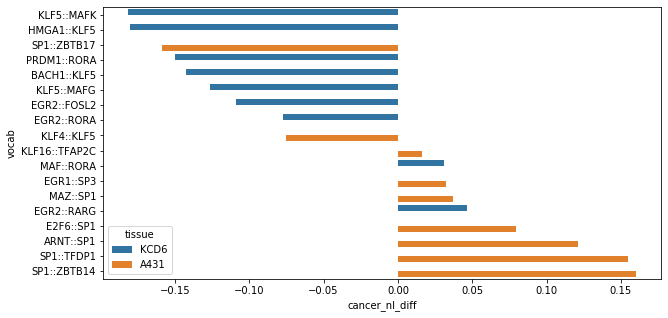

In [119]:
plot_df = scc_krt_df_KCD6.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'median'}).reset_index().sort_values('cancer_nl_diff')#.cancer_nl_diff.sort_values().plot.bar()
figure = plt.gcf()

# figure.set_size_inches(10,10)
# sns.barplot(data=plot_df, y='vocab',x='cancer_nl_diff',hue='tissue')
# plt.savefig('../data/processed/mpra/scc_krt_df_KCD6_cancer_nl.pdf', dpi=300)

# plt.figure()
# plot_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'median'}).reset_index().sort_values('cancer_nl_diff')#.cancer_nl_diff.sort_values().plot.bar()
# figure = plt.gcf()

# figure.set_size_inches(10,18)
# sns.barplot(data=plot_df, y='vocab',x='cancer_nl_diff',hue='tissue')
# plt.savefig('../data/processed/mpra/scc_krt_df_cancer_nl.pdf', dpi=300)

plt.figure()
plot_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'median'}).reset_index().sort_values('cancer_nl_diff')#.cancer_nl_diff.sort_values().plot.bar()
figure = plt.gcf()
figure.set_size_inches(10,5)
sns.barplot(data=plot_df[plot_df.vocab.isin(scc_krtd6_vocabs)], y='vocab',x='cancer_nl_diff',hue='tissue')
plt.savefig('../data/processed/mpra/scc_krt_df_cancer_nl_coop.pdf', dpi=300)



In [60]:
scc_krt_df_A431.to_csv('../../miseq/mpraanalyze_results/dk_norm_cooperativity/scc_krt_df_A431.csv')
scc_krt_df_KCD6.to_csv('../../miseq/mpraanalyze_results/dk_norm_cooperativity/scc_krt_df_KCD6.csv')


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


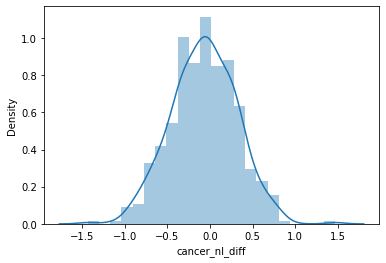

In [51]:
# plot_df_kcd6_coop = normlog_vocab_df_coop[normlog_vocab_df_coop.tissue.isin(['KCD6','A431'])&normlog_vocab_df_coop.mpra_tissue.isin(['KCD6','A431'])&(normlog_vocab_df_coop.orient=='A_B_coop')]
sns.distplot(scc_krt_df_KCD6.cancer_nl_diff) 
# plot_df_kcd6_coop

mpra_tissue,vocab_instance,A431,KCD6,vocab,tissue,instance,cancer_nl_diff
0,ARID5B::KLF5+KCD6+1,-0.700571,-0.504824,ARID5B::KLF5,KCD6,1,-0.195748
1,ARID5B::KLF5+KCD6+10,5.706725,5.463452,ARID5B::KLF5,KCD6,10,0.243273
2,ARID5B::KLF5+KCD6+2,-2.301308,-2.206076,ARID5B::KLF5,KCD6,2,-0.095232
3,ARID5B::KLF5+KCD6+3,0.778848,1.112637,ARID5B::KLF5,KCD6,3,-0.333790
4,ARID5B::KLF5+KCD6+4,5.252679,5.812443,ARID5B::KLF5,KCD6,4,-0.559765
...,...,...,...,...,...,...,...
885,STAT3::UBP1+KCD6+5,3.390000,4.110000,STAT3::UBP1,KCD6,5,-0.720000
886,STAT3::UBP1+KCD6+6,0.145000,-0.479000,STAT3::UBP1,KCD6,6,0.624000
887,STAT3::UBP1+KCD6+7,-4.160000,-3.150000,STAT3::UBP1,KCD6,7,-1.010000
888,STAT3::UBP1+KCD6+8,-0.478000,-0.604000,STAT3::UBP1,KCD6,8,0.126000


In [133]:
# additive
scc_krt_df = normlog_vocab_df_coop[normlog_vocab_df_coop.tissue.isin(['KCD6','A431'])]
scc_krt_df = scc_krt_df[scc_krt_df.mpra_tissue.isin(['A431','KCD6'])]
scc_krt_df = scc_krt_df[scc_krt_df.orient=='A_B_add']
scc_krt_df['vocab_instance'] = scc_krt_df.vocab+'+'+scc_krt_df.tissue+'+'+scc_krt_df.instance.map(str)
scc_krt_df = scc_krt_df.pivot(index='vocab_instance',columns='mpra_tissue',values='value').reset_index()
scc_krt_df[['vocab','tissue','instance']] = scc_krt_df.vocab_instance.str.split('+',expand=True)
scc_krt_df['cancer_nl_diff'] = scc_krt_df.A431-scc_krt_df.KCD6
# scc_krt_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'mean'}).reset_index()
# sns.violinplot(x="tissue", y="cancer_nl_diff", data=scc_krt_df) 
# scc_krt_df.groupby(['tissue']).describe()
scc_krt_df_A431 = scc_krt_df[scc_krt_df.tissue=='A431']
scc_krt_df_KCD6 = scc_krt_df[scc_krt_df.tissue=='KCD6']
print('Wilcoxan rank-sum test for KC& SCC vocab additive')
print(scipy.stats.wilcoxon(scc_krt_df.KCD6, y=scc_krt_df.A431, zero_method='wilcox', correction=False, alternative='greater'))

print('Wilcoxan rank-sum test for SCC vocab additive')
print(scipy.stats.wilcoxon(scc_krt_df_A431.KCD6, y=scc_krt_df_A431.A431, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for KCD6 vocab additive')

print(scipy.stats.wilcoxon(scc_krt_df_KCD6.KCD6, y=scc_krt_df_KCD6.A431, zero_method='wilcox', correction=False, alternative='greater'))

print('Wilcoxan rank-sum test for KC coop vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df_KCD6[scc_krt_df_KCD6.vocab.isin(scc_krtd6_vocabs)].KCD6, y=scc_krt_df_KCD6[scc_krt_df_KCD6.vocab.isin(scc_krtd6_vocabs)].A431, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for SCC coop vocab cooperativity')
print(scipy.stats.wilcoxon(scc_krt_df_A431[scc_krt_df_A431.vocab.isin(scc_krtd6_vocabs)].A431, y=scc_krt_df_A431[scc_krt_df_A431.vocab.isin(scc_krtd6_vocabs)].KCD6, zero_method='wilcox', correction=False, alternative='greater'))



Wilcoxan rank-sum test for KC& SCC vocab additive
WilcoxonResult(statistic=217043.5, pvalue=0.13222990744702223)
Wilcoxan rank-sum test for SCC vocab additive
WilcoxonResult(statistic=46246.0, pvalue=0.2591398857968997)
Wilcoxan rank-sum test for KCD6 vocab additive
WilcoxonResult(statistic=62899.5, pvalue=0.19008910296829762)
Wilcoxan rank-sum test for KC coop vocab cooperativity
WilcoxonResult(statistic=2149.0, pvalue=0.341488397529391)
Wilcoxan rank-sum test for SCC coop vocab cooperativity
WilcoxonResult(statistic=2180.0, pvalue=0.2969687635671322)


# MM vocabs

In [120]:
mm_mc_df = normlog_vocab_df_coop[normlog_vocab_df_coop.tissue.isin(['COLO','MC'])]
mm_mc_df = mm_mc_df[mm_mc_df.mpra_tissue.isin(['COLO','MC'])]
mm_mc_df = mm_mc_df[mm_mc_df.orient=='A_B_coop']
mm_mc_df['vocab_instance'] = mm_mc_df.vocab+'+'+mm_mc_df.tissue+'+'+mm_mc_df.instance.map(str)
mm_mc_df = mm_mc_df.pivot(index='vocab_instance',columns='mpra_tissue',values='value').reset_index()
mm_mc_df[['vocab','tissue','instance']] = mm_mc_df.vocab_instance.str.split('+',expand=True)
mm_mc_df['cancer_nl_diff'] = mm_mc_df.COLO-mm_mc_df.MC
# scc_krt_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'mean'}).reset_index()
# sns.violinplot(x="tissue", y="cancer_nl_diff", data=scc_krt_df) 
# scc_krt_df.groupby(['tissue']).describe()
mm_mc_df_COLO = mm_mc_df[mm_mc_df.tissue=='COLO']
mm_mc_df_MC = mm_mc_df[mm_mc_df.tissue=='MC']
print('Wilcoxan rank-sum test for MM & MC vocab cooperativity')
print(scipy.stats.wilcoxon(mm_mc_df.MC, y=mm_mc_df.COLO, zero_method='wilcox', correction=False, alternative='greater'))


print('Wilcoxan rank-sum test for MM vocab cooperativity')
print(scipy.stats.wilcoxon(mm_mc_df_COLO.MC, y=mm_mc_df_COLO.COLO, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for MC vocab cooperativity')

print(scipy.stats.wilcoxon(mm_mc_df_MC.MC, y=mm_mc_df_MC.COLO, zero_method='wilcox', correction=False, alternative='greater'))



Wilcoxan rank-sum test for MM & MC vocab cooperativity
WilcoxonResult(statistic=123703.0, pvalue=0.0008563138935557343)
Wilcoxan rank-sum test for MM vocab cooperativity
WilcoxonResult(statistic=48940.0, pvalue=4.3946914951667675e-05)
Wilcoxan rank-sum test for MC vocab cooperativity
WilcoxonResult(statistic=17017.5, pvalue=0.4398957151642588)


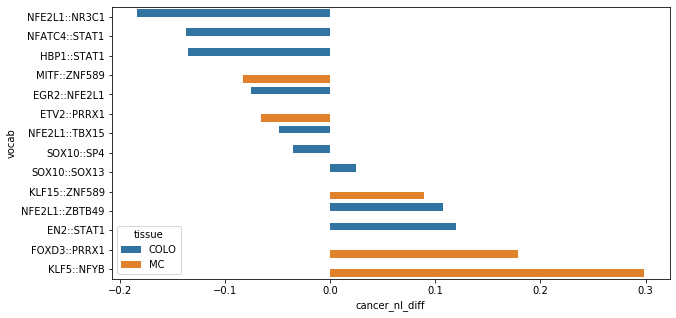

In [126]:

# figure.set_size_inches(10,10)
# sns.barplot(data=plot_df, y='vocab',x='cancer_nl_diff',hue='tissue')
# plt.savefig('../data/processed/mpra/scc_krt_df_KCD6_cancer_nl.pdf', dpi=300)

# plt.figure()
# plot_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'median'}).reset_index().sort_values('cancer_nl_diff')#.cancer_nl_diff.sort_values().plot.bar()
# figure = plt.gcf()

# figure.set_size_inches(10,18)
# sns.barplot(data=plot_df, y='vocab',x='cancer_nl_diff',hue='tissue')
# plt.savefig('../data/processed/mpra/scc_krt_df_cancer_nl.pdf', dpi=300)

plt.figure()
plot_df = mm_mc_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'median'}).reset_index().sort_values('cancer_nl_diff')#.cancer_nl_diff.sort_values().plot.bar()
figure = plt.gcf()
figure.set_size_inches(10,5)
sns.barplot(data=plot_df[plot_df.vocab.isin(mc_mm_vocabs)], y='vocab',x='cancer_nl_diff',hue='tissue')
plt.savefig('../data/processed/mpra/scc_mc_mm_cancer_nl_coop.pdf', dpi=300)



In [63]:
mm_mc_df_COLO.to_csv('../../miseq/mpraanalyze_results/dk_norm_cooperativity/mm_mc_df_COLO.csv')
mm_mc_df_MC.to_csv('../../miseq/mpraanalyze_results/dk_norm_cooperativity/mm_mc_df_MC.csv')


In [67]:
mm_mc_df = normlog_vocab_df_coop[normlog_vocab_df_coop.tissue.isin(['COLO','MC'])]
mm_mc_df = mm_mc_df[mm_mc_df.mpra_tissue.isin(['COLO','MC'])]
mm_mc_df = mm_mc_df[mm_mc_df.orient=='A_B_add']
mm_mc_df['vocab_instance'] = mm_mc_df.vocab+'+'+mm_mc_df.tissue+'+'+mm_mc_df.instance.map(str)
mm_mc_df = mm_mc_df.pivot(index='vocab_instance',columns='mpra_tissue',values='value').reset_index()
mm_mc_df[['vocab','tissue','instance']] = mm_mc_df.vocab_instance.str.split('+',expand=True)
mm_mc_df['cancer_nl_diff'] = mm_mc_df.COLO-mm_mc_df.MC
# scc_krt_df = scc_krt_df.groupby(['vocab','tissue']).agg({'cancer_nl_diff':'mean'}).reset_index()
# sns.violinplot(x="tissue", y="cancer_nl_diff", data=scc_krt_df) 
# scc_krt_df.groupby(['tissue']).describe()
mm_mc_df_COLO = mm_mc_df[mm_mc_df.tissue=='COLO']
mm_mc_df_MC = mm_mc_df[mm_mc_df.tissue=='MC']
print('Wilcoxan rank-sum test for MM & MC vocab additive')
print(scipy.stats.wilcoxon(mm_mc_df.MC, y=mm_mc_df.COLO, zero_method='wilcox', correction=False, alternative='greater'))


print('Wilcoxan rank-sum test for MM vocab additive')
print(scipy.stats.wilcoxon(mm_mc_df_COLO.MC, y=mm_mc_df_COLO.COLO, zero_method='wilcox', correction=False, alternative='greater'))
print('Wilcoxan rank-sum test for MC vocab additive')

print(scipy.stats.wilcoxon(mm_mc_df_MC.MC, y=mm_mc_df_MC.COLO, zero_method='wilcox', correction=False, alternative='greater'))



Wilcoxan rank-sum test for MM & MC vocab additive
WilcoxonResult(statistic=119683.5, pvalue=0.01038863944344363)
Wilcoxan rank-sum test for MM vocab additive
WilcoxonResult(statistic=45758.5, pvalue=0.0072302134157665185)
Wilcoxan rank-sum test for MC vocab additive
WilcoxonResult(statistic=17444.5, pvalue=0.26896388874275756)


# 3. for all cell types

A. The degree predicted cell type specific vocabularies actually drove cell type specific expression in the MPRA. This point is actually pretty opaque to me still as the paper and figures were configured initially and if we had some correlation matrix to specifically show this, it could help make the central point of the paper. So, putting cell type specific DNA motif combinations [maybe colored by cell type] on one edge of the matrix and cell type-specific MPRA activity on the other edge with enrichment score heat map would be one way to address this central and critical gap in the paper. You can be certain that not only the Reviewers but even the Editors will kill the paper on initial screening without this clear information. I apologize that I did not push for clarity on this as the figures were being drafted.
 
B. The degree to which malignant cells A) engage activity of new synergistic DNA motif combinations (DMCs) versus B) differentially modulating existing normal lineage DMCs and C) the putative target genes and their biological processes for each. As configured, the figures don’t address this and I cant figure it out but you can bet the Reviewers will demand this also.
Neoplastic cells engage new DMCs – these need to be more clearly shown, quantified, and maybe should go into a supplementary table
Neoplastic cells differentially modulate DMCs active in their normal counterparts that mediate neoplasia-relevant processes – the same, with the biological impact emphasized – a venn diagram for KC/cSCC and MC/MM of shared and unique DMCs would help address both points
The target genes of the normal unique DMCs, the cancer unique DMCs, and the overlapping DMCs in GO would be critical here

In [16]:
# for normal cell types
nl_tissues = ['Colon', 'GM', 'MC', 'KCD6']
and_vocabs = new_mpra_df[new_mpra_df.consensus_class=='AND'].vocab.unique()
print(len(and_vocabs))
normlog_vocab_df_coop

53


,vocab,instance,tissue,mpra_tissue,orient,value
1,ARID5B::KLF5,1,KCD6,A431,A_B_coop,-0.178150
2,ARID5B::KLF5,1,KCD6,A431,A_B_add,-0.700571
3,ARID5B::KLF5,1,KCD6,COLO,A_B_coop,-0.239885
4,ARID5B::KLF5,1,KCD6,COLO,A_B_add,-0.184670
5,ARID5B::KLF5,1,KCD6,Colon,A_B_coop,-0.085290
...,...,...,...,...,...,...
28676,ZFX::E2F6,9,A431,GM,A_B_add,-2.000000
28677,ZFX::E2F6,9,A431,KCD6,A_B_coop,2.430000
28678,ZFX::E2F6,9,A431,KCD6,A_B_add,-1.660000
28679,ZFX::E2F6,9,A431,MC,A_B_coop,3.280000


# are the values in the correct tissue higher than they are in other tissues

for normal vocabs

In [17]:
def get_vocab_specificity(tissues_arr, 
                          normlog_vocab_df_coop=normlog_vocab_df_coop, 
                          and_vocabs=and_vocabs,vocab_to_class=vocab_to_class):
    vocab_info_dict = {}
    num_tissues = len(tissues_arr)
    for idx,vocab_tissue in enumerate(vocab_arr):
        vocab, tissue = vocab_tissue.split('+')
        # get two arrays one for tissue other not for tissue
        df = normlog_vocab_df_coop[normlog_vocab_df_coop.orient=='A_B_coop'].sort_values('instance')
        df = df[df.vocab==vocab]
        tissue = df.tissue.unique()[0]

        if tissue in tissues_arr:
            # for the wilcoxon rank-sum way
            tissue_val_arr = df[df.mpra_tissue==df.tissue].value.values
            nontissue_val_arr = df[df.mpra_tissue!=df.tissue].groupby('instance').agg({'value':'mean'}).value.values

            normlog_vocab_df_coop
            pval = scipy.stats.wilcoxon(tissue_val_arr, nontissue_val_arr,  alternative='greater').pvalue

    #         # for the kruskal wallis test way + getting rankings
    #         df_nl = df[df.mpra_tissue.isin(nl_tissues)]
    #         df_nl = df_nl.groupby('mpra_tissue').agg({'value':['median',list]}).reset_index()
    #         df_nl.columns = ['mpra_tissue','median','values_list']
    #         df_nl['rank_median'] = df_nl['median'].rank(method='average',ascending=False)
    #         df_nl['rank_list'] = df_nl['values_list'].rank(method='average',ascending=False)

    #         pval = scipy.stats.kruskal(df_nl['values_list'][0],df_nl['values_list'][1],
    #                     df_nl['values_list'][2],df_nl['values_list'][3]).pvalue

            vocab_info_dict[idx] = [vocab,tissue, pval]
    vocab_cell_type_sig_df = pd.DataFrame.from_dict(vocab_info_dict,orient='index',columns=['vocab','tissue','pval'])
    vocab_cell_type_sig_df['consensus_class'] = vocab_cell_type_sig_df.vocab.map(vocab_to_class)
    vocab_cell_type_sig_df['is_and']= vocab_cell_type_sig_df.vocab.isin(and_vocabs)
    return vocab_cell_type_sig_df

In [18]:
# vocab_info_dict = {}
# num_tissues = len(nl_tissues)
# for idx,vocab_tissue in enumerate(vocab_arr):
#     vocab, tissue = vocab_tissue.split('+')
#     # get two arrays one for tissue other not for tissue
#     df = normlog_vocab_df_coop[normlog_vocab_df_coop.orient=='A_B_coop'].sort_values('instance')
#     df = df[df.vocab==vocab]
#     tissue = df.tissue.unique()[0]

#     if tissue in nl_tissues:
#         # for the wilcoxon rank-sum way
#         tissue_val_arr = df[df.mpra_tissue==df.tissue].value.values
#         nontissue_val_arr = df[df.mpra_tissue!=df.tissue].groupby('instance').agg({'value':'mean'}).value.values
        
#         normlog_vocab_df_coop
#         pval = scipy.stats.wilcoxon(tissue_val_arr, nontissue_val_arr,  alternative='greater').pvalue
        
# #         # for the kruskal wallis test way + getting rankings
# #         df_nl = df[df.mpra_tissue.isin(nl_tissues)]
# #         df_nl = df_nl.groupby('mpra_tissue').agg({'value':['median',list]}).reset_index()
# #         df_nl.columns = ['mpra_tissue','median','values_list']
# #         df_nl['rank_median'] = df_nl['median'].rank(method='average',ascending=False)
# #         df_nl['rank_list'] = df_nl['values_list'].rank(method='average',ascending=False)

# #         pval = scipy.stats.kruskal(df_nl['values_list'][0],df_nl['values_list'][1],
# #                     df_nl['values_list'][2],df_nl['values_list'][3]).pvalue
    
#         vocab_info_dict[idx] = [vocab,tissue, pval]
    

In [25]:
vocab_cell_type_sig_df = get_vocab_specificity(nl_tissues)
vocab_cell_type_sig_df.to_csv('../data/processed/mpra/vocab_cell_type_sig_df_norm.csv')
vocab_cell_type_sig_df_filt = vocab_cell_type_sig_df[ (vocab_cell_type_sig_df.pval<0.10)]
print(vocab_cell_type_sig_df_filt.shape)
vocab_cell_type_sig_df_filt

(27, 5)


,vocab,tissue,pval,consensus_class,is_and
0,ARID5B::KLF5,KCD6,0.084403,OR,False
6,ASCL2::KLF4,KCD6,0.057064,OR,False
11,BARX2::THAP1,Colon,0.037231,OR,False
19,E2F7::THAP1,Colon,0.046300,AND,True
26,EGR2::FOSL2,KCD6,0.029668,AND,True
27,EGR2::JUN,KCD6,0.029668,other,False
28,EGR2::JUNB,KCD6,0.002531,other,False
29,EGR2::KLF4,KCD6,0.046300,LEADING,False
33,EGR2::RORA,KCD6,0.046300,AND,True
51,FLI1::FOXM1,Colon,0.057064,other,False


In [30]:
vocab_cell_type_sig_df = get_vocab_specificity(['A431','KCD6'])
vocab_cell_type_sig_df.to_csv('../data/processed/mpra/vocab_cell_type_sig_df_scc_kcd6.csv')
vocab_cell_type_sig_df_filt = vocab_cell_type_sig_df[ (vocab_cell_type_sig_df.pval<0.10)]
print(vocab_cell_type_sig_df_filt.shape)
vocab_cell_type_sig_df_filt[vocab_cell_type_sig_df_filt.consensus_class=='AND']

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


(25, 5)


,vocab,tissue,pval,consensus_class,is_and
5,ARNT::SP1,A431,0.057064,AND,True
26,EGR2::FOSL2,KCD6,0.029668,AND,True
33,EGR2::RORA,KCD6,0.046300,AND,True
67,HMGA1::KLF5,KCD6,0.014208,AND,True
129,KLF5::MAFK,KCD6,0.037231,AND,True
185,PRDM1::RORA,KCD6,0.014208,AND,True
217,SP1::ZBTB14,A431,0.046300,AND,True
220,SP1::ZNF770,A431,0.014201,AND,True


In [29]:
vocab_cell_type_sig_df = get_vocab_specificity(['COLO','MC'])
vocab_cell_type_sig_df.to_csv('../data/processed/mpra/vocab_cell_type_sig_df_mm_mc.csv')
vocab_cell_type_sig_df_filt = vocab_cell_type_sig_df[ (vocab_cell_type_sig_df.pval<0.10)]
print(vocab_cell_type_sig_df_filt.shape)
vocab_cell_type_sig_df_filt

(6, 5)


,vocab,tissue,pval,consensus_class,is_and
31,EGR2::NFE2L1,COLO,0.046300,AND,True
155,MITF::PRRX1,MC,0.057064,LEADING,False
167,NFE2L1::NR3C1,COLO,0.046300,AND,True
188,PRRX1::SOX10,MC,0.034352,other,False
203,SOX10::SOX13,COLO,0.057064,AND,True
231,STAT1::UBP1,COLO,0.084403,other,False
